In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from testsuite import generate_state_space, get_distribution, generate_iid_samples
%precision 4
%matplotlib inline

# DREAM Implementation

**Source**: *Vrugt, J. A. (2016). Markov chain Monte Carlo simulation using the DREAM software package: Theory, concepts, and MATLAB implementation. Environmental Modelling & Software, 75, 273-316.*

## Pre-defined parameters and fucntions

It is necessary to pre-define some parameters and functions for the DREAM algorithm, in which those components strictly follow the implementation methods in the original paper.

### Main parameters

| Parameter | Initial Value | Definition | 
| ---- | ---- | ---- |
| $N$ | 5000 |  number of steps |
| $D$ | 2 | dimension | 
| $P$ | 10 | number of chains|
| $n_{CR}$ | 3 | number of Crossover Rate (CR) values |
| $\delta$ | 3 | maximum number of chain pairs used to generate the jump |

### Auxiliary parameters

| Parameter | Initial Value | Definition | 
| ---- | ---- | ---- |
| $c$ | 0.1 | $e \in \mathcal{U}_d(-c, c)$ with $c$ small | 
| $c^*$ | $10^{-12}$ | $\varepsilon_d \in \mathcal{N}_d(0, c^*)$ with $c^*$ small |
| $p_g$ | 0.2 | selection weight for $\gamma$ (choosing $1$ or $\gamma = \sqrt{2.38\delta^* d}$) |
| $CR$ | \[1/3, 2/3, 3/3\] | CR values | 
| $\Delta$ | \[0, 0, 0\] | the squared normalized jump distance for each CR value | 
| $f_{CR}$ | \[0, 0, 0\] | an $n_{CR}$-vector to record the frequency of each CR value being selected | 
| $p_{CR}$ | \[1/3, 1/3, 1/3\] | probabilities for CR values | 

In [2]:
delta, c, c_star, n_CR, p_g = 3, 0.1, 1e-12, 3, 0.2
Delta = np.zeros(shape=(1, n_CR))
f_CR = np.zeros(shape=(1, n_CR))
CR = np.arange(start=1, stop=n_CR+1)/n_CR
p_CR = np.ones(shape=(1, n_CR))/n_CR

### Initial state and probability density function (pdf)

To run the DREAM algorithm, the state and its probability density function should be introduced in advance. 

In the paper, $\mathbf X$ is the population state, which contains $P$ $d$-dimensional points. And $p_X$ stores the density of $\mathbf X$. Similarly, $\mathbf x$ denotes the whole populations, in which there are $N$ rows (steps) and $P$ $d$-dimensional points in each row. Besides, $p_x$ is the density of $\mathbf x$.

| Denotation | Meaning | Size |
| ---- | ---- | ---- | 
| $\mathbf X$ | population state | $P \times D$ | 
| $p_X$ | current population density | $P \times 1$ | 
| $\mathbf x$ | all the chains | $N \times D \times P$ | 
| $p_x$ | all the densities | $N\times P$ |

In [3]:
def generate_initial_population(nb_chains, dim):
    return np.array(np.random.uniform(low=-10, high=10, size=nb_chains*dim).reshape((nb_chains, dim)))

def generate_initial_density(nb_chains):
    return np.array(np.zeros(shape=(nb_chains, 1)))

### *Append* from current state to the population

After updating the current state, instant results append to the whole population. Remember that $\mathbf X$ is a $P \times D$ matrix, and $\mathbf x$ is an $N \times D \times P$ matrix. 

To implement this operation in Python, we have to transpose the $\mathbf X$ to a $D \times P$ matrix and then append it to the position $n$ in $\mathbf x$. This is the same to appending the density. We first transpose the $p_X$ to an $1 \times P$ matrix, then append it to the position $n$ in $p_x$. Here, $n$ is the step number.

In [4]:
def append_chain(chains, current_chains, dim, nb_chains, n):
    chains[n] = np.reshape(np.transpose(current_chains), newshape=(dim, nb_chains))
    return chains

def append_density(density, current_density, n):
    density[n] = np.transpose(current_density)
    return density

### Initialize the state and the density

The current state $\mathbf X$ and the density of the current state $p_X$ will be generated at the beginning. The DREAM algorithm then appends them to the population $\mathbf x$ and the whole density $p_x$, respectively.  

Note that, the process above is regarded as the first loop. Consequently, the step number in the main DREAM process is from $1$ to $N-1$, instead of $0$ to $N-1$.

In [5]:
def calculate_pdf(current_chains, nb_chains):
    current_density = generate_initial_density(nb_chains=nb_chains)
    for i in range(nb_chains):
        current_density[i] = pdf(current_chains[i, :])
    return current_density

In [6]:
def initialize_chains(nb_steps, nb_chains, dim, pdf):
    initial_state = generate_initial_population(nb_chains=nb_chains, dim=dim)
    initial_density = calculate_pdf(initial_state, nb_chains)
    population = np.zeros(shape=(nb_steps, dim, nb_chains))
    density = np.zeros(shape=(nb_steps, nb_chains))
    population = append_chain(chains=population, current_chains=initial_state, dim=dim, nb_chains=nb_chains, n=0)
    density = append_density(density=density, current_density=initial_density, n=0)
    return initial_state, initial_density, population, density

## Propose the pre-candidate
A pre-candidate $\mathbf x_d^*$ is generated as shown in Equation $1$ below.

$$\mathbf x_d^* = \mathbf x_n^{(p)} + (1+e)I_d \sigma \sum_{j=1}^{\delta^*} (\mathbf x_n^{(a_j)}-\mathbf x_n^{(b_j)}) + \varepsilon_d \tag{1}$$
where $\delta^* \in \{1, 2, \dots, \delta\}$ signifies the number of pairs used to make differences for generating the candidate. $e \in \mathcal{U}_d(-c, c)$ and $\varepsilon_d \in \mathcal{N}_d(0, c^*)$ with $c$ and $c^*$ small compared to the width of the target distribution.

### Generate two index arrays
$\sum_{j=1}^{\delta^*} (x_n^{(a_j)}-x_n^{(b_j)})$ is the sum of $\delta^*$ different chains in the population state. $a_j$ and $b_j$ both store $\delta^*$ indices of points in the population state. Those indices are different with each other and not equal to $p$. To achieve that, $2 \delta^*$ indices are selected from integers $0$ to $P-1$. If an index is equal to the index of chain for update, we sample once again until the requirements are well met. Otherwise, those indices are assigned to two arrays as $a_j$ and $b_j$.

In [7]:
def generate_two_random_arrays(nb_chains, selected_delta, index_of_chain):
    array_candidate = np.random.choice(range(nb_chains), size=2*selected_delta, replace=False)
    for k in range(len(array_candidate)):
        if array_candidate[k] == index_of_chain:
            generate_two_random_arrays(nb_chains, selected_delta, index_of_chain)
        else:
            return array_candidate[: selected_delta], array_candidate[selected_delta :]

### Sum of the differences
Calculate the sum of differences of pairs of chains as $\sum_{j=1}^{\delta^*} (x_n^{(a_j)}-x_n^{(b_j)})$.

In [8]:
def calculate_difference(current_chains, selected_delta, index_of_chain, nb_chains):
    a, b = generate_two_random_arrays(nb_chains, selected_delta, index_of_chain)
    total_sum = 0
    for j in range(len(a)):
        temp = 0
        temp = current_chains[a[j]] - current_chains[b[j]]
        total_sum = total_sum + temp
    return total_sum

### Generate the pre-candidate $\mathbf x_d^*$
$\sigma$ is calculated by $\sigma(\delta^*, d) = 2.38/\sqrt{2\delta^*d}$. And a mix probability $p_g$ is used to select between $\sigma$ and $1$. Finally, the pre-candidate is well generated. 

In [9]:
def generate_candidate(chain, population_state, delta, index_of_chain, dim, nb_chains):
    delta_star = int(np.random.choice(range(delta), size = 1)) + 1
    sigma_candidate = 2.38/np.sqrt(2*delta_star*dim)
    sigma = np.random.choice([sigma_candidate, 1], size = 1, replace = 'true', p = [1-p_g, p_g])
    return chain + (1 + np.random.uniform(-c, c, 1)) * sigma * calculate_difference(population_state, delta_star, index_of_chain, nb_chains) + c_star * np.random.normal(size = D)

## Subsapce sampling

Suppose we consider a $d$-dimensional chain in the current state. Only selected dimensions are going to be updated. And the indices of those dimensions will be stored in the subspace set $A$.

Technically,  one index called $idx$ is randomly selected in the range of integers 1 to $n_{CR}$ (number of crossover values).  Then, $d$ values are stored in $\mu$, which are randomly selected in the range from $0$ to $1$. Note that those $d$ values are sorted, and their subscripts are used to represent indices of dimensions. Finally, we pick up all the values that less than the $idx$th element in CR values. Their subscripts are the dimensions going to be updated. In case that there is no dimension being selected, a random dimension is assigned to the subspace set $A$.

In [10]:
def generate_subspace(n_CR, p_CR, CR, dim):
    idx = np.random.choice(range(n_CR), size=1, p=p_CR[0])
    mu = np.random.uniform(low=0, high=1, size=dim)
    subspace = list(np.where(mu < CR[idx]))[0]
    if len(subspace) == 0:
        subspace = np.random.choice(dim, size=1)
    return subspace, idx

## Make up candidate $\mathbf x^*$

This step is to combine components from the chain going to update $x_n^{(p)}$ and the full candidate $x_d^*$. The components of the chain in subspace are replaced by those of the full candidate.

In the documentation, we use matrix operation as Equation .

$$
x^* = [S_{\bar{A}} \ \ S_A]\ 
		\left[ \begin{array}{c}
		x_n^{(p)} \\ x_d^*
	\end{array} \right]
$$
where the $i$th diagonal component in $S_A$ is $1$, if $i \in A$; $0$ otherwise. And the $i$th diagonal component in $S_{\bar{A}}$ is $0$, if $i \in A$; $1$ otherwise.

Here, we use a more straightforward way to implement the idea above. 

In [11]:
def make_up_candidate(subspace, chain, pre_candidate, dim):
    candidate = []
    for i in range(dim):
        if i in subspace:
            candidate.append(pre_candidate[i])
        else:
            candidate.append(chain[i])
    return candidate

## Accept or reject the proposal

### Metropolis-Hastings algorithm

In [12]:
def MH_acceptance_ratio(current, candidate, pdf):
    p_current, p_candidate = pdf(current), pdf(candidate)
    return p_candidate/p_current

In [13]:
def accept_p(acceptance_ratio):
    return np.random.rand() < acceptance_ratio

### Update the point

In [14]:
def update_point(point, chains, n_CR, p_CR, CR, delta, index_of_chain, dim, nb_chains):
    subspace, idx = generate_subspace(n_CR, p_CR, CR, dim)
    pre_candidate = generate_candidate(point, chains, delta, index_of_chain, dim, nb_chains)
    candidate = make_up_candidate(subspace, point, pre_candidate, dim)
    acceptance_ratio = min(1, MH_acceptance_ratio(point, candidate, pdf))
    if accept_p(acceptance_ratio):
        return candidate, idx, pdf(candidate), candidate - point
    else:
        return point, idx, pdf(point), np.zeros(shape=(dim))

## Update the CR PMF
To update the CR PMF, we introduce a measurement named _squared normalized jumping distance_.

$$\Delta_{i} \leftarrow \Delta_{i} + \sum_{k=1}^d \left( \frac{X_{n,k}^{(p)}-X_{n-1,k}^{(p)}}{r_j} \right)^2 \tag{2}$$
where $r_j$ is the *standard deviation* of the last state $\mathbf X_{n-1, j}^{(p)}$. $\Delta$ then stores the squared normalized jumping distance of a full-dimension jump for _each index of CR values_. The total squared normalized jumping distances in each CR value are sequently stored in $\Delta$ after a chain evolution. It evaluates _the distance of the point jumps_ under each CR value. 

The frequency that a CR value is selected in a chain evolution are also recorded simultaneously and are stored in a list $n$.

$$f_{CR, i} \leftarrow f_{CR, i} + 1 \tag{3}$$

In [15]:
def generate_parameters_for_update_crossover(idx, std_dev, distance):
    Delta[0][idx] = Delta[0][idx] + sum((distance/std_dev)**2)
    f_CR[0][idx] = f_CR[0][idx] + 1
    return Delta, f_CR

After a chain evolution, we calculate the new selection probability as follows:

$$p_{CR} \leftarrow \frac{\Delta}{n} \tag{4}$$

$$p_{CR} \leftarrow \frac{p_{CR}}{\sum p_{CR}} \tag{5}$$

Equation 4 calculates the average squared normalized jumping distance for each CR value. In other words, the distance that the point jumps averagely once the certain CR value is selected. Large jumps are tend to be selected, so _the probability to selecting the corresponding CR value should be enlarged_. But the sum of the $p_{CR}$ now might not be 1, Equation 5 is thus used for standardization. 

In [16]:
def update_CR_PMF(Delta, f_CR):
    return (Delta/f_CR) / np.sum(Delta/f_CR)

## Chain evolution
A chain evolution is defined as all the chains in the current state have finished updating their states.

In [17]:
def chain_evolution(chains, std_X, n_CR, p_CR, CR, delta, dim, nb_chains):
    for i in range(P):
        chains[i], idx, pdf_of_population_state, distance = update_point(chains[i], chains, n_CR, p_CR, CR, delta, i, dim, nb_chains)
        Delta, f_CR = generate_parameters_for_update_crossover(idx, std_X, distance)
    return chains, Delta, f_CR, pdf_of_population_state

## Correction for outlier chains
After each chain evolution, the check for location of the chains is important, because the outlier chains will _lead the results to a situation where each chain is out of target distribution and slow down the speed of convergence_.

To solve this problem, we introduce **Inter-Quartile-Range** (**IQR**), a measure of statistical dispersion. It is equal to the difference between 75th and 25th percentiles, $IQR = Q_3 - Q_1$. The IQR is a measure of variability,  based on dividing a data set into quartiles. Quartiles divide a rank-ordered data set into four equal parts. The values that separate parts are called the first, second, and third quartiles; and they are denoted by $Q_1$, $Q_2$ and $Q_3$, respectively.

In [18]:
def mean_log(pdf_of_chains, n):
    return np.mean(np.log(pdf_of_chains[int(n/2):n]), axis = 0)

In [19]:
def iqr_cal(mean_log_mat):
    q3, q1 = np.percentile(mean_log_mat, [75, 25])
    iqr = q3 - q1
    return q1 - 2*iqr #Here, the original paper uses 2*iqr to calculate the outlier

Based on theory mentioned above, We can illustrate Outlier chains handling method in DREAM. DREAM stores in $\Omega$ _the mean of the logarithm of the posterior densities of the last 50% of the samples in each chain_. Through the IQR statistic, IQR is calculated. And chains with $\Omega < Q_1 - 2IQR$ are considered outliers, and are _moved to the current best member of $\mathbf X$_.

In [20]:
def check(population_state, pdf_of_whole_population, pdf_of_population_state, step, nb_chains):
    mean_log_mat = mean_log(pdf_of_whole_population, step)
    thres = iqr_cal(mean_log_mat)
    replace = np.where(np.max(mean_log_mat))
    MOVE = np.where(mean_log_mat < thres)
    if len(MOVE) == 0:
        return population_state, pdf_of_population_state
    else:
        for i in MOVE:
            population_state[i] = population_state[replace]
        pdf_of_population_state = calculate_pdf(population_state, nb_chains)
        return population_state, pdf_of_population_state

In [21]:
def standard_deviation(current_chains):
    return np.std(current_chains, axis = 0)

## Gelman-Rubin Diagnostic

In [22]:
def gelman_rubin_diagnostic(chains):
    #calculate within chain varinace
    W = np.zeros(shape = (D))
    for i in range(P):
        for j in range(D):
            temp = np.std(chains[:, j, i])**2
            W[j] = W[j] + temp
    W = W/P
    
    #calculate between chain variance
    mean_collect = np.zeros(shape = (P, D))
    mean_mat = np.zeros(shape = (D))
    for i in range(P):
        for j in range(D):
            mean_collect[i, j] = np.mean(chains[:, j, i])
    for k in range(D):
        mean_mat[k] = np.mean(mean_collect[:, k])
    B_component = np.zeros(shape = (P, D))
    for p in range(P):
        for q in range(D):
            B_component[p, q] = (mean_collect[p, q] - mean_mat[q])**2
    B = np.zeros(shape = D)
    for d in range(D):
        B[d] = np.sum(B_component[:, d])
    B = N*B/P
    
    var_theta = (1 - 1/(2*N)) * W + 1/(2*N)*B
    return np.sqrt(var_theta/W)

## A Single DREAM Experiment

### Set parameters

In [23]:
N, P, D = 5000, 10, 2

### Generate target distribution

In [24]:
# Available values for 'target_name': "Pi_3", "Pi_4"
target_name = "Pi_3"
SP = generate_state_space(dim=D, N=N)
TARGET = SP['Test Suite'][target_name]
pdf = TARGET['pdf']

### Main DREAM 

In [25]:
def dream(population_state, pdf_of_pop_state,  whole_population, pdf_of_whole_pop, pdf, p_CR, dim, nb_chains):
    for n in range(1, N):
        std_X = standard_deviation(population_state)
        population_state, Delta, f_CR, pdf_of_pop_state = chain_evolution(population_state, std_X, n_CR, p_CR, CR, delta, dim, nb_chains)
        whole_population = append_chain(whole_population, population_state, dim, nb_chains, n)
        p_x = append_density(pdf_of_whole_pop, pdf_of_pop_state, n)
        if n < N/10:
            p_CR = update_CR_PMF(Delta, f_CR)
        population_state, pdf_of_pop_state = check(population_state, pdf_of_whole_pop, pdf_of_pop_state, n, nb_chains)
    return whole_population, pdf_of_whole_pop

### One-time run DREAM

In [26]:
def run_dream(nb_step, nb_chains, dim, pdf):
    X, p_X, x, p_x = initialize_chains(nb_step, nb_chains, dim, pdf)
    samples, pdf_samples = dream(X, p_X, x, p_x, pdf, p_CR, dim, nb_chains)
    return samples, pdf_samples

### Samples generated and their pdf

In [27]:
samples, pdf_samples = run_dream(N, P, D, pdf)

### Gelman-Rubin diagnostic

In [28]:
gr_diag = gelman_rubin_diagnostic(samples)

In [29]:
gr_diag

array([1.0008, 1.0007])

### Plot samples 

In [30]:
def plot(chain, nb_chain, target_name):
    plt.figure(dpi = 600)
    n = 256
    x = np.linspace(-35, 35, n)
    y = np.linspace(-100, 20, n)
    X, Y = np.meshgrid(x, y)
    plt.contour(X,Y, SP['Test Suite'][target_name]['Contour Function'](X,Y), levels =SP['Test Suite'][target_name]['Contour Levels'], colors='k', alpha=0.4, linewidth = 0.1)
    plt.xlim(-40, 40)
    plt.ylim(-30, 10)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.scatter(chain[int(N/2):N, 0, nb_chain], chain[int(N/2):N, 1, nb_chain], color='black')

/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


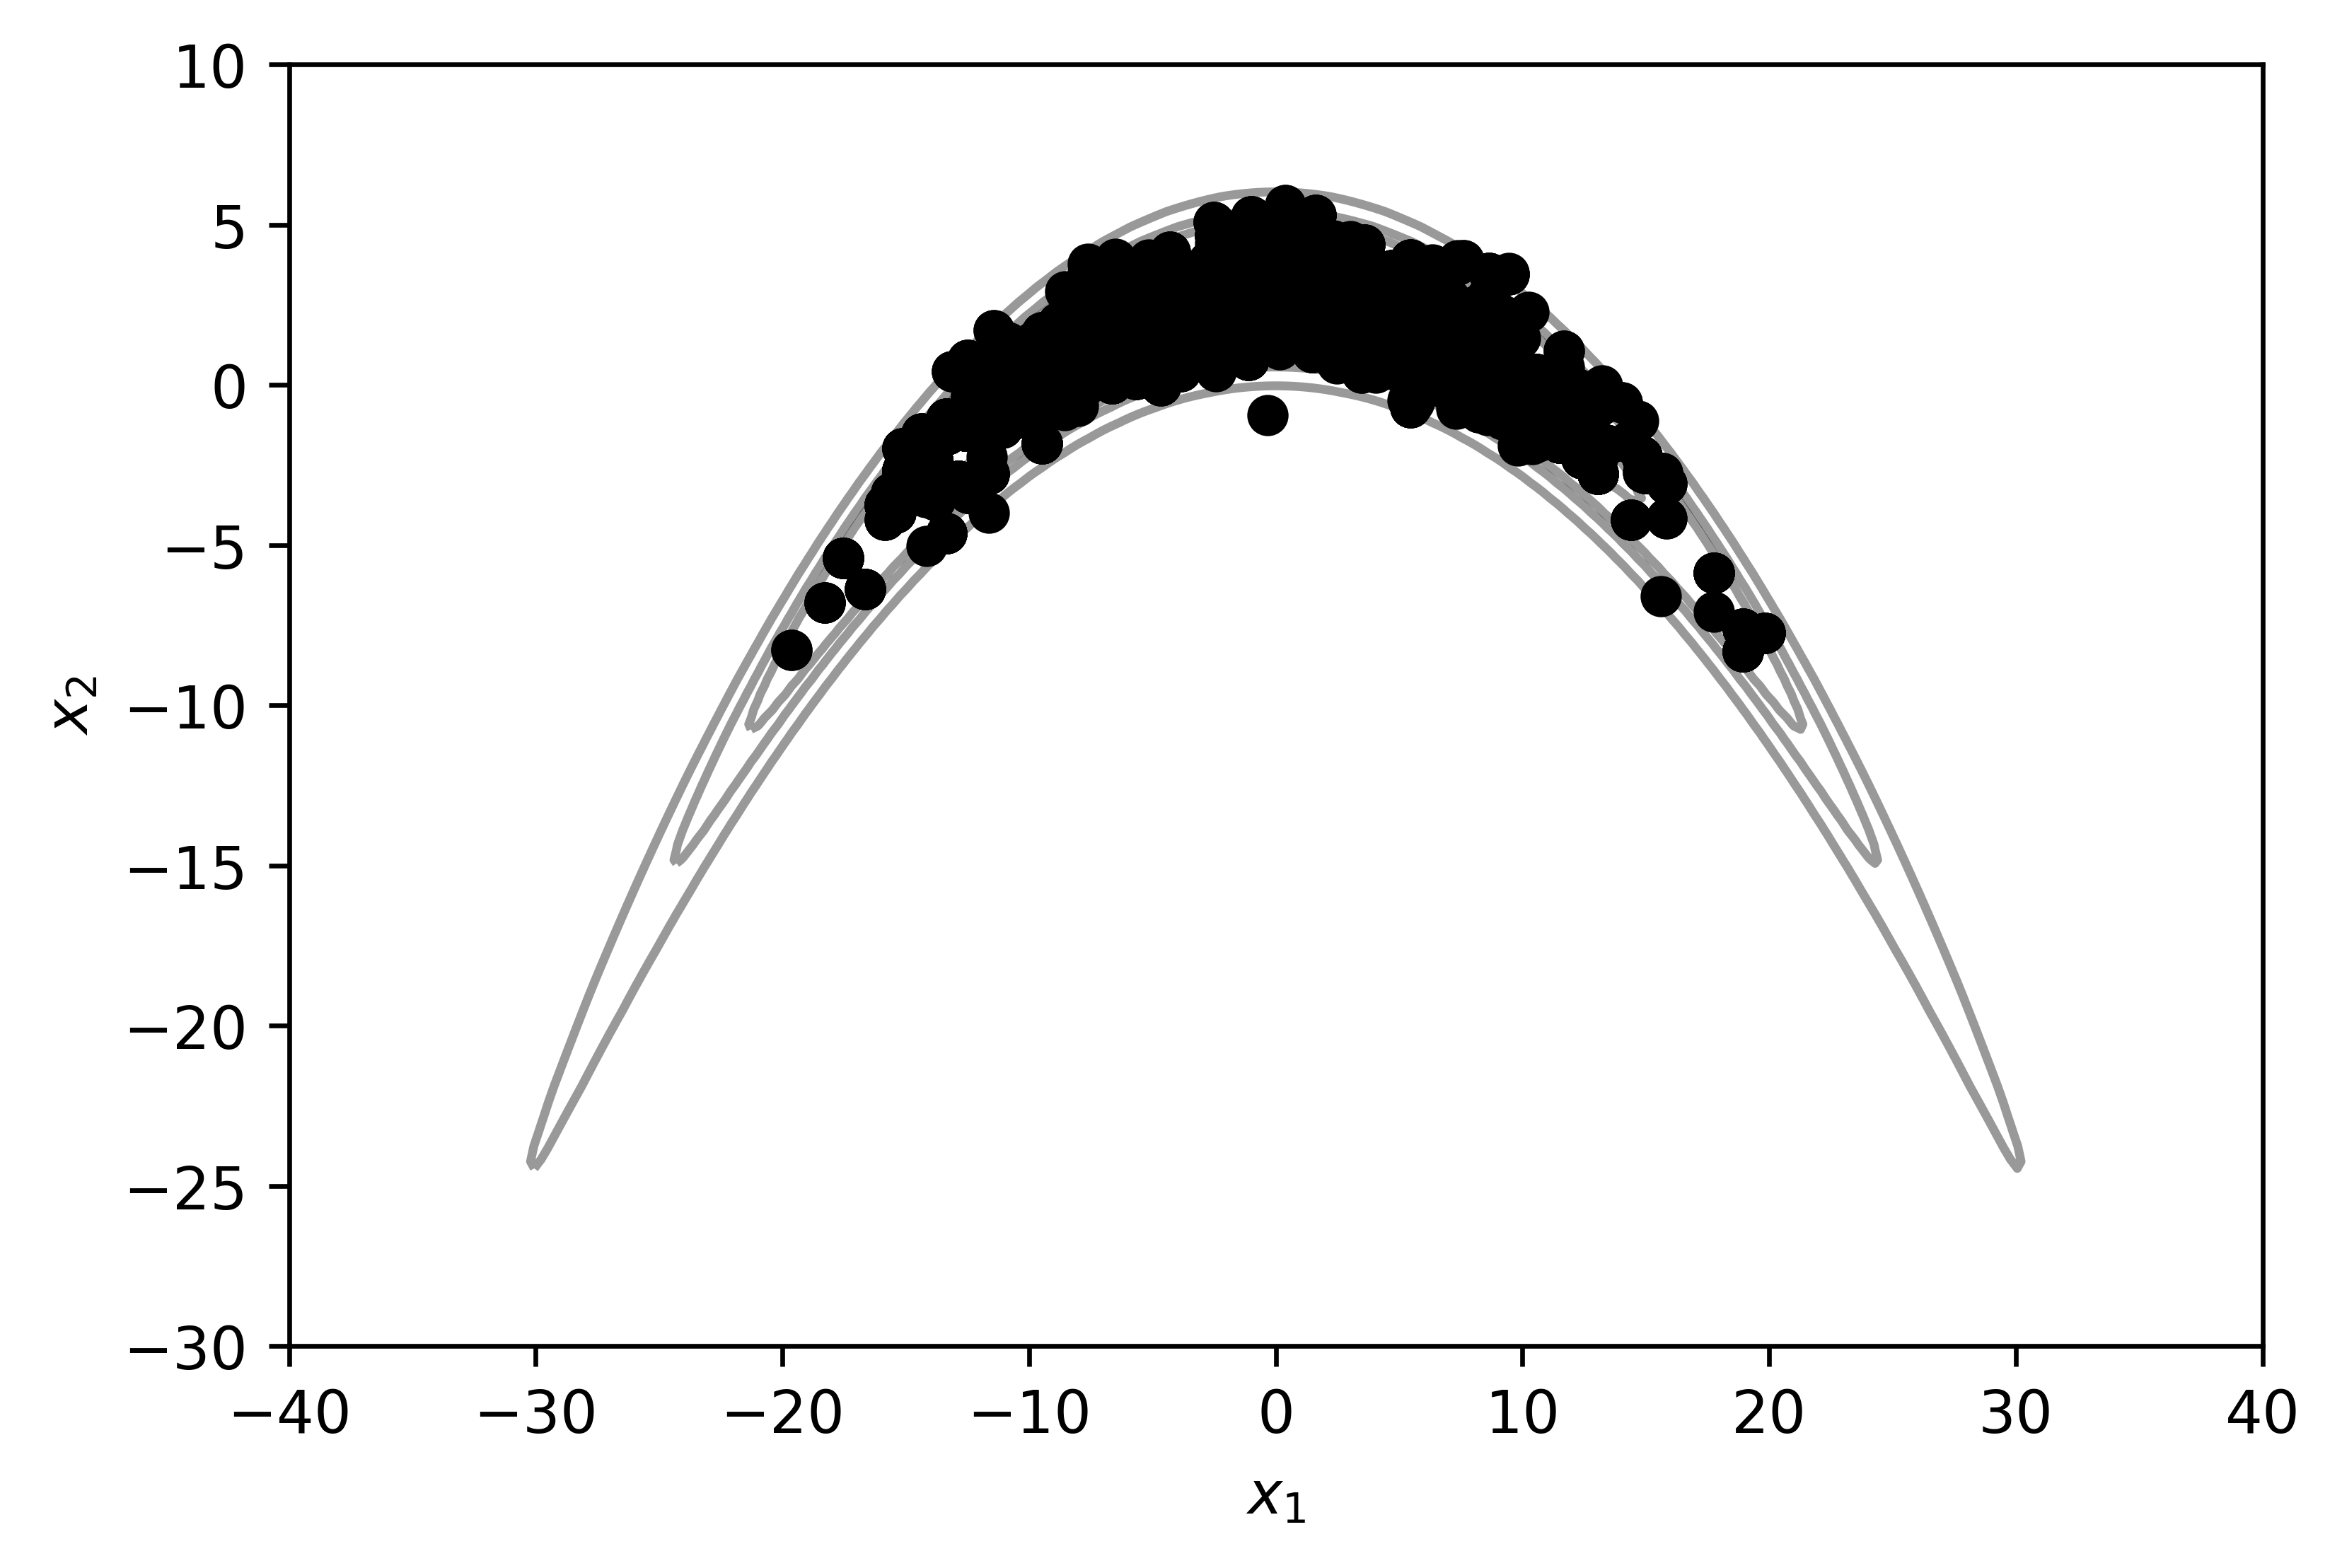

In [31]:
plot(samples, 4, target_name)

### Autocorrelation

In [32]:
def autocorrelation(series, max_lag=1000):
    x = series - np.mean(series)
    xnorm = np.sum(x**2)
    autocor = np.correlate(x, x, "same")/xnorm 
    origin = int(np.floor(len(autocor)/2))
    return autocor[origin:origin+max_lag]

def plot_autocorrelation(sample, color, label):
    plt.figure(dpi = 600)
    plt.hlines(0, 0, 1000, colors = "k", linestyles = "dashed", alpha=0.4)
    plt.plot(autocorrelation(sample), color=color, label=label)

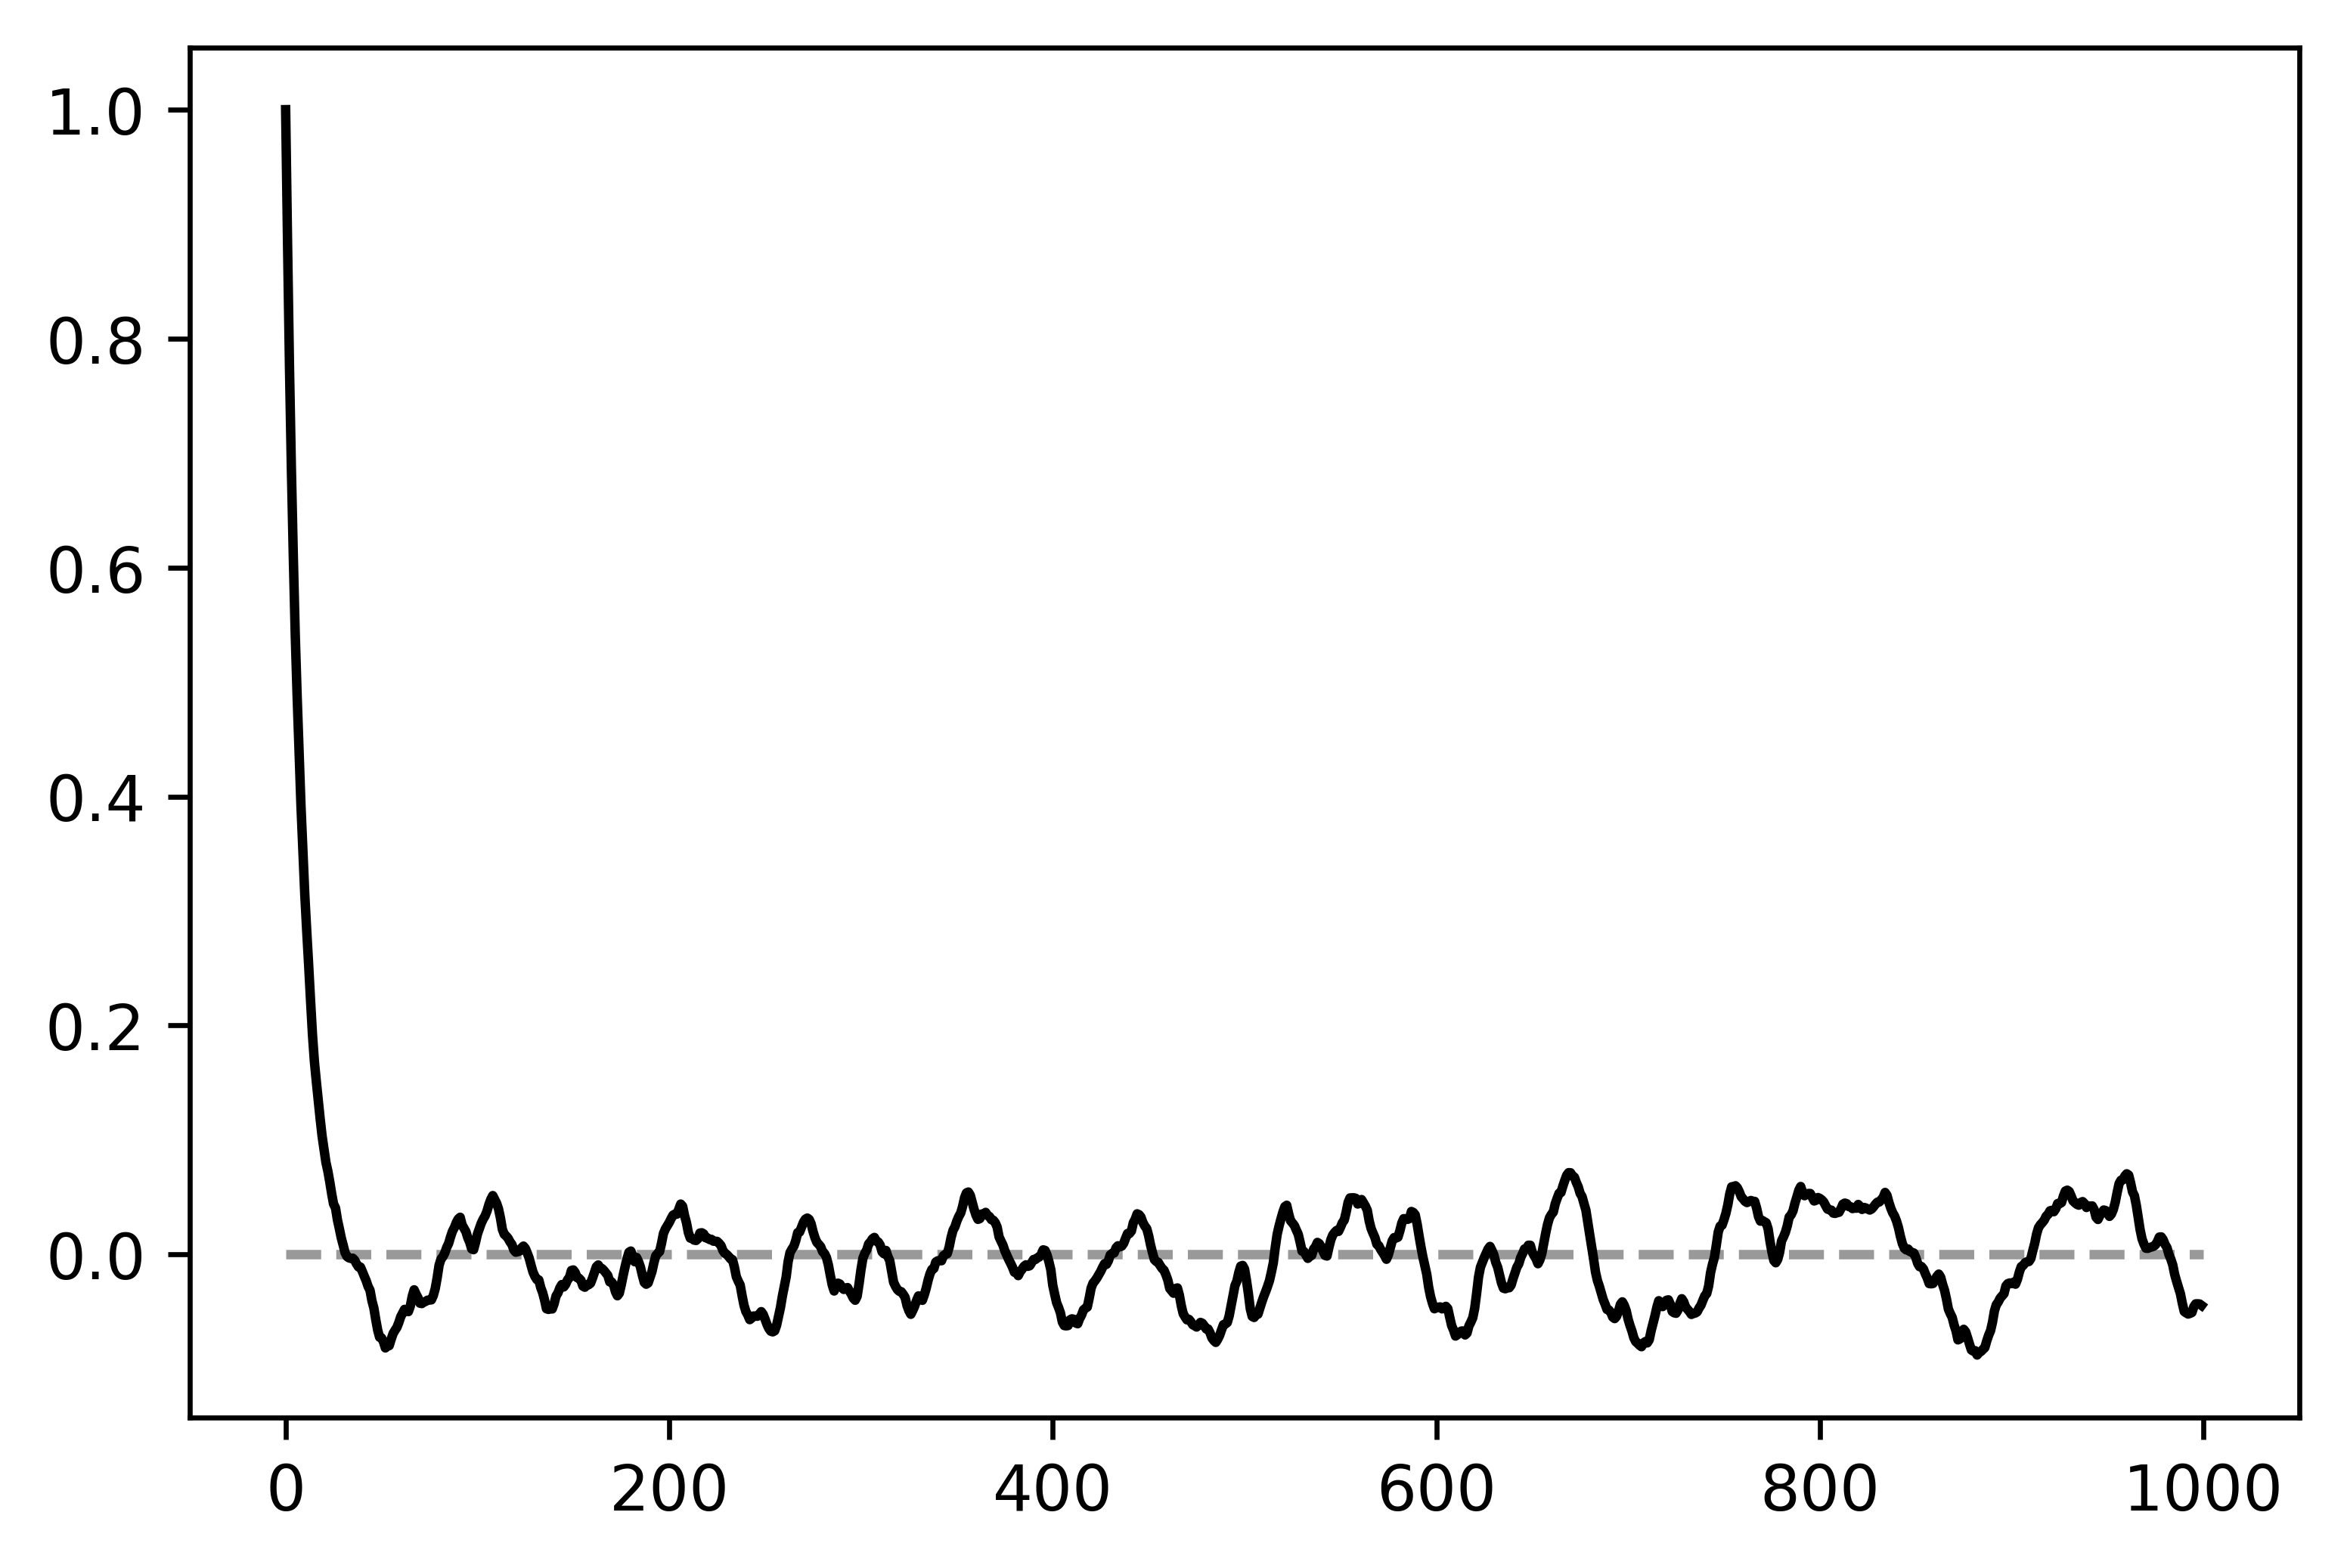

In [33]:
plot_autocorrelation(samples[:,1,0], 'k', 't')